In [16]:
import pandas as pd
import numpy as np
import hts
from datetime import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

from urllib.parse import urlparse
import mlflow
import mlflow.sklearn
import logging

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
%config InlineBackend.figure_format = 'retina'

In [66]:
# load the data 
df = pd.read_csv("Natural Gas.csv")
df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)
df.Date = pd.to_datetime(df.Date)
# lowercase the column names
df.columns = [col_name.lower() for col_name in df.columns]

In [68]:
df.head()

state       date   consumption
0                     Alabama 2022-03-01  2.971680e+04
1                     Alabama 2022-02-01  2.652128e+04
2                     Alabama 2022-01-01  3.752025e+04
3                     Alabama 2021-12-01  3.280868e+04
4                     Alabama 2021-11-01  3.323293e+04
5                     Alabama 2021-10-01  3.137131e+04
6                     Alabama 2021-09-01  3.326254e+04
7                     Alabama 2021-08-01  4.034098e+04
8                     Alabama 2021-07-01  3.827582e+04
9                     Alabama 2021-06-01  3.669753e+04
10                    Alabama 2021-05-01  2.862207e+04
11                    Alabama 2021-04-01  2.371253e+04
12                    Alabama 2021-03-01  2.520327e+04
13                    Alabama 2021-02-01  2.663772e+04
14                    Alabama 2021-01-01  3.318849e+04
15                    Alabama 2020-12-01  3.192296e+04
16                    Alabama 2020-11-01  2.364951e+04
17                    Alabama 2020-10-01  3.036416e+04
18                    Alabama 2020-09-01  3.564795e+04
19                    Alabama 2020-08-01  4.184195e+04
20                    Alabama 2020-07-01  4.697261e+04
21                    Alabama 2020-06-01  3.963008e+04
22                    Alabama 2020-05-01  3.095783e+04
23                    Alabama 2020-04-01  2.193190e+04
24                    Alabama 2020-03-01  3.220643e+04
25                    Alabama 2020-02-01  3.067120e+04
26                    Alabama 2020-01-01  3.037632e+04
27                    Alabama 2019-12-01  2.828153e+04
28                    Alabama 2019-11-01  2.943219e+04
29                    Alabama 2019-10-01  3.509193e+04
30                    Alabama 2019-09-01  4.326620e+04
31                    Alabama 2019-08-01  4.459855e+04
32                    Alabama 2019-07-01  4.396029e+04
33                    Alabama 2019-06-01  3.880920e+04
34                    Alabama 2019-05-01  3.626820e+04
35                    Alabama 2019-04-01  2.724431e+04
36                    Alabama 2019-03-01  3.531541e+04
37                    Alabama 2019-02-01  2.804294e+04
38                    Alabama 2019-01-01  2.862147e+04
39                    Alabama 2018-12-01  3.069112e+04
40                    Alabama 2018-11-01  3.159838e+04
41                    Alabama 2018-10-01  3.692859e+04
42                    Alabama 2018-09-01  4.287087e+04
43                    Alabama 2018-08-01  4.242224e+04
44                    Alabama 2018-07-01  4.417279e+04
45                    Alabama 2018-06-01  3.860957e+04
46                    Alabama 2018-05-01  3.950291e+04
47                    Alabama 2018-04-01  3.362616e+04
48                    Alabama 2018-03-01  3.106426e+04
49                    Alabama 2018-02-01  2.518054e+04
50                    Alabama 2018-01-01  3.423886e+04
51                    Alabama 2017-12-01  3.041319e+04
52                    Alabama 2017-11-01  3.061693e+04
53                    Alabama 2017-10-01  3.159571e+04
54                    Alabama 2017-09-01  3.436337e+04
55                    Alabama 2017-08-01  3.960678e+04
56                    Alabama 2017-07-01  4.169971e+04
57                    Alabama 2017-06-01  3.123751e+04
58                    Alabama 2017-05-01  3.094022e+04
59                    Alabama 2017-04-01  2.995711e+04
60                    Alabama 2017-03-01  3.158488e+04
61                    Alabama 2017-02-01  2.280515e+04
62                    Alabama 2017-01-01  2.521709e+04
63                    Alabama 2016-12-01  3.101499e+04
64                    Alabama 2016-11-01  3.055120e+04
65                    Alabama 2016-10-01  3.164542e+04
66                    Alabama 2016-09-01  4.018517e+04
67                    Alabama 2016-08-01  4.307015e+04
68                    Alabama 2016-07-01  4.414159e+04
69                    Alabama 2016-06-01  3.900576e+04
70                    Alabama 2016-05-01  3.304402e+04
71                    Alabama 2016-04-01  2.624684e+04
72       

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15555 entries, 0 to 15554
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   state        15555 non-null  object        
 1   date         15555 non-null  datetime64[ns]
 2   consumption  15555 non-null  float64       
 3   year         15555 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 486.2+ KB


In [5]:
# create the state level df
df_state_level = df.groupby(["date", "state"]) \
                    .sum() \
                    .reset_index(drop=False) \
                    .pivot(index="date", columns="state", values="consumption")

# create the total level df
df_total = df.groupby("date")["consumption"] \
             .sum() \
             .to_frame() \
             .rename(columns={"consumption": "total"})

# join the DataFrames
hierarchy_df = df_state_level.join(df_total)


#Train test split
hierarchy_df = hierarchy_df.reset_index(drop=False)
startdate = np.datetime64("2001-01-01")
enddate = np.datetime64("2021-12-01")
print(startdate)
print(enddate)
hierarchy_train_df=hierarchy_df[(hierarchy_df['date'] >= startdate) & (hierarchy_df['date'] <= enddate)]
hierarchy_test_df=hierarchy_df[(hierarchy_df['date'] > enddate)]

hierarchy_df = hierarchy_df.set_index("date")
hierarchy_df.index = pd.to_datetime(hierarchy_df.index)
hierarchy_df = hierarchy_df.resample("MS").sum()

hierarchy_train_df = hierarchy_train_df.set_index("date")
hierarchy_train_df.index = pd.to_datetime(hierarchy_train_df.index)
hierarchy_train_df = hierarchy_train_df.resample("MS").sum()       

hierarchy_test_df = hierarchy_test_df.set_index("date")
hierarchy_test_df.index = pd.to_datetime(hierarchy_test_df.index)
hierarchy_test_df = hierarchy_test_df.resample("MS").sum()
                           

print(f"Number of time series at the bottom level: {df_state_level.shape[1]}")

2001-01-01
2021-12-01
Number of time series at the bottom level: 60


In [135]:
print(hierarchy_train_df.shape)
hierarchy_train_df.tail()

(252, 61)


Alabama    Alaska    Arizona   Arkansas  California   Colorado  \
date                                                                           
2021-08-01  40340.979  2843.555  41549.341  15054.254   74125.341  12934.901   
2021-09-01  33262.537  2096.356  34906.122  12696.947   61405.636  10062.071   
2021-10-01  31371.307  2131.413  26824.227  13756.024   55562.500   7076.037   
2021-11-01  33232.928  2152.128  20954.375  16457.822   50309.210   8455.344   
2021-12-01  32808.683  1846.261  24825.472  14688.466   52669.329   8050.897   

            Connecticut  Delaware  East North Central  East South Central  \
date                                                                        
2021-08-01    17279.857  4023.194          134077.562          101711.458   
2021-09-01    13935.000  1600.990           92254.763           79230.513   
2021-10-01    12203.171  1245.600          108173.563           72721.179   
2021-11-01    16479.390  2179.595          106431.616           76045.112   
2021-12-01    13891.565  2652.757          101698.944           76859.647   

               Florida    Georgia     Idaho   Illinois    Indiana      Iowa  \
date                                                                          
2021-08-01  139305.922  42447.856  3747.947  31032.033  21066.701  5525.588   
2021-09-01  126445.213  34050.372  3036.976  17474.536  15187.249  3286.282   
2021-10-01  119133.058  35996.528  2405.423  20242.482  17404.445  3712.490   
2021-11-01   92110.968  37290.110  3068.837  19603.824  18067.904  4029.465   
2021-12-01   96375.222  37231.932  2829.269  16464.767  17980.243  3030.211   

              Kansas   Kentucky  Louisiana     Maine   Maryland  \
date                                                              
2021-08-01  3100.204  11886.534  33738.013  1943.760  11094.670   
2021-09-01  1932.781   8000.551  22697.828  1224.241   9059.452   
2021-10-01  1828.802   9444.362  27333.451  2033.851  10610.171   
2021-11-01  1455.141  10081.673  25590.350  1727.679   9929.876   
2021-12-01  1403.694  10186.658  23092.650  1149.984   7581.702   

            Massachusetts   Michigan  Middle Atlantic   Minnesota  \
date                                                                
2021-08-01      13930.740  28497.827        168497.885  10613.870   
2021-09-01       8185.536  20064.882        132621.411   7168.878   
2021-10-01       8591.094  21383.348        126096.502   9544.150   
2021-11-01       6654.733  21333.402        123361.205   8753.244   
2021-12-01       7913.977  18799.195        128621.794   7174.938   

            Mississippi  Missouri  Montana   Mountain  Nebraska     Nevada  \
date                                                                         
2021-08-01    36993.057  9272.330  668.174  99402.368  1960.612  22460.593   
2021-09-01    28724.413  5338.448  594.995  80848.042   896.324  18444.317   
2021-10-01    26544.396  4729.941  557.531  59670.768  1071.078  13351.267   
2021-11-01    26316.806  4823.702  372.876  57931.862  1304.863  13072.382   
2021-12-01    27644.166  4017.617  422.896  62847.427   664.089  14329.706   

            New England   New Hampshire   New Jersey   New Mexico   New York   \
date                                                                            
2021-08-01     44174.221        4471.973    27704.877     9194.978  56700.824   
2021-09-01     32585.192        3908.392    20068.630     7085.824  36467.814   
2021-10-01     32852.938        4105.623    22475.898     4994.656  36955.649   
2021-11-01     31178.618        1635.869    19484.554     5220.854  35306.303   
2021-12-01     29029.212        1447.239    15380.424     5072.580  35059.474   

            North Carolina   North Dakota        Ohio   Oklahoma     Oregon  \
date                                                                          
2021-08-01        39067.278       1509.713  36204.641  33126.544  14769.074   
2021-09-01        30991.202       1090.098  27888.607

In [136]:
print(hierarchy_test_df.shape)
hierarchy_test_df.head(30)

(3, 61)


Alabama    Alaska    Arizona   Arkansas  California  Colorado  \
date                                                                          
2022-01-01  37520.247  2200.891  19739.142  15984.575    45699.03  9739.341   
2022-02-01  26521.280  1826.377  18926.480   7717.748    37344.53  9212.010   
2022-03-01  29716.799  1427.167  21127.454  13942.117    35052.31  8807.106   

            Connecticut  Delaware  East North Central  East South Central  \
date                                                                        
2022-01-01    13583.692  1514.852          131256.086          100682.790   
2022-02-01    12484.101  1581.794          103342.870           72546.568   
2022-03-01    13415.654  1031.346           96002.044           74043.705   

               Florida    Georgia     Idaho   Illinois    Indiana      Iowa  \
date                                                                          
2022-01-01  105259.995  36964.621  3135.896  21475.298  22714.179  3246.557   
2022-02-01   85181.984  29079.449  2707.459  14445.212  18122.783  2670.386   
2022-03-01   98224.988  28419.926  1564.227  11204.985  15740.148  2053.872   

              Kansas   Kentucky  Louisiana     Maine  Maryland  Massachusetts  \
date                                                                            
2022-01-01     0.000  15651.179  29911.818  1966.559  4919.889      11007.274   
2022-02-01  1364.346   9570.507  24055.160  1489.025  4519.128       8870.678   
2022-03-01  1410.450   5915.302  20887.745  1677.352  7714.077       7998.405   

             Michigan  Middle Atlantic   Minnesota  Mississippi  Missouri  \
date                                                                        
2022-01-01  27481.707        130772.617   8060.265    36111.870  6473.191   
2022-02-01  21518.359        119884.326   5752.082    27344.566  3710.145   
2022-03-01  21119.511        118262.640   4384.852    27072.289  3194.729   

            Montana   Mountain  Nebraska     Nevada  New England   \
date                                                                
2022-01-01  362.817  60040.878   794.203  14271.617     32310.694   
2022-02-01  267.798  54940.306   549.178  12603.680     28233.071   
2022-03-01  228.330  54326.705     0.000  12393.205     28765.028   

            New Hampshire   New Jersey   New Mexico   New York   \
date                                                              
2022-01-01        1562.414    14502.360     5525.077  37322.259   
2022-02-01        1464.105    16173.768     5055.670  33562.325   
2022-03-01        1893.009    15757.436     4899.157  30228.618   

            North Carolina   North Dakota        Ohio   Oklahoma     Oregon  \
date                                                                          
2022-01-01        36234.500       1136.169  44044.282  20238.757  12631.199   
2022-02-01        36536.056        951.325  35853.680  17648.620  10773.569   
2022-03-01        30477.014        735.319  37260.010  11302.056   9190.858   

            Pacific Contiguous   Pacific Noncontiguous   Pennsylvania  \
date                                                                    
2022-01-01           133291.908                2200.891     78947.998   
2022-02-01           110737.716                1826.377     70148.233   
2022-03-01            98156.564                1427.167     72276.586   

            Rhode Island   South Atlantic   South Carolina   South Dakota   \
date                                                                         
2022-01-01       4190.199       230138.023        14531.387        733.993   
2022-02-01       3925.162       196305.110        13066.664        527.761   
2022-03-01       3778.843       206817.527        11230.323          0.000   

            Tennessee       Texas  United States       Utah  Vermont  \
date                                                                   
2022-01-01  11399.494  136378.173      979025.732  6941.267    0.

In [8]:
#shortterm hierarchy
states = df["state"].unique()
total = {'total': list(states)}
hierarchy = {**total}
hierarchy

{'total': ['Alabama',
  'Alaska',
  'Arizona',
  'Arkansas',
  'California',
  'Colorado',
  'Connecticut',
  'Delaware',
  'East North Central',
  'East South Central',
  'Florida',
  'Georgia',
  'Idaho',
  'Illinois',
  'Indiana',
  'Iowa',
  'Kansas',
  'Kentucky',
  'Louisiana',
  'Maine',
  'Maryland',
  'Massachusetts',
  'Michigan',
  'Middle Atlantic ',
  'Minnesota',
  'Mississippi',
  'Missouri',
  'Montana',
  'Mountain',
  'Nebraska',
  'Nevada',
  'New England ',
  'New Hampshire ',
  'New Jersey ',
  'New Mexico ',
  'New York ',
  'North Carolina ',
  'North Dakota ',
  'Ohio',
  'Oklahoma',
  'Oregon',
  'Pacific Contiguous ',
  'Pacific Noncontiguous ',
  'Pennsylvania',
  'Rhode Island ',
  'South Atlantic ',
  'South Carolina ',
  'South Dakota ',
  'Tennessee',
  'Texas',
  'United States ',
  'Utah',
  'Vermont',
  'Virginia',
  'Washington',
  'West North Central',
  'West South Central',
  'West Virginia ',
  'Wisconsin',
  'Wyoming']}

In [9]:
from hts.hierarchy import HierarchyTree

ht = HierarchyTree.from_nodes(nodes=hierarchy, df=hierarchy_train_df)
ht

- total
   |- Alabama
   |- Alaska
   |- Arizona
   |- Arkansas
   |- California
   |- Colorado
   |- Connecticut
   |- Delaware
   |- East North Central
   |- East South Central
   |- Florida
   |- Georgia
   |- Idaho
   |- Illinois
   |- Indiana
   |- Iowa
   |- Kansas
   |- Kentucky
   |- Louisiana
   |- Maine
   |- Maryland
   |- Massachusetts
   |- Michigan
   |- Middle Atlantic 
   |- Minnesota
   |- Mississippi
   |- Missouri
   |- Montana
   |- Mountain
   |- Nebraska
   |- Nevada
   |- New England 
   |- New Hampshire 
   |- New Jersey 
   |- New Mexico 
   |- New York 
   |- North Carolina 
   |- North Dakota 
   |- Ohio
   |- Oklahoma
   |- Oregon
   |- Pacific Contiguous 
   |- Pacific Noncontiguous 
   |- Pennsylvania
   |- Rhode Island 
   |- South Atlantic 
   |- South Carolina 
   |- South Dakota 
   |- Tennessee
   |- Texas
   |- United States 
   |- Utah
   |- Vermont
   |- Virginia
   |- Washington
   |- West North Central
   |- West South Central
   |- West Virginia

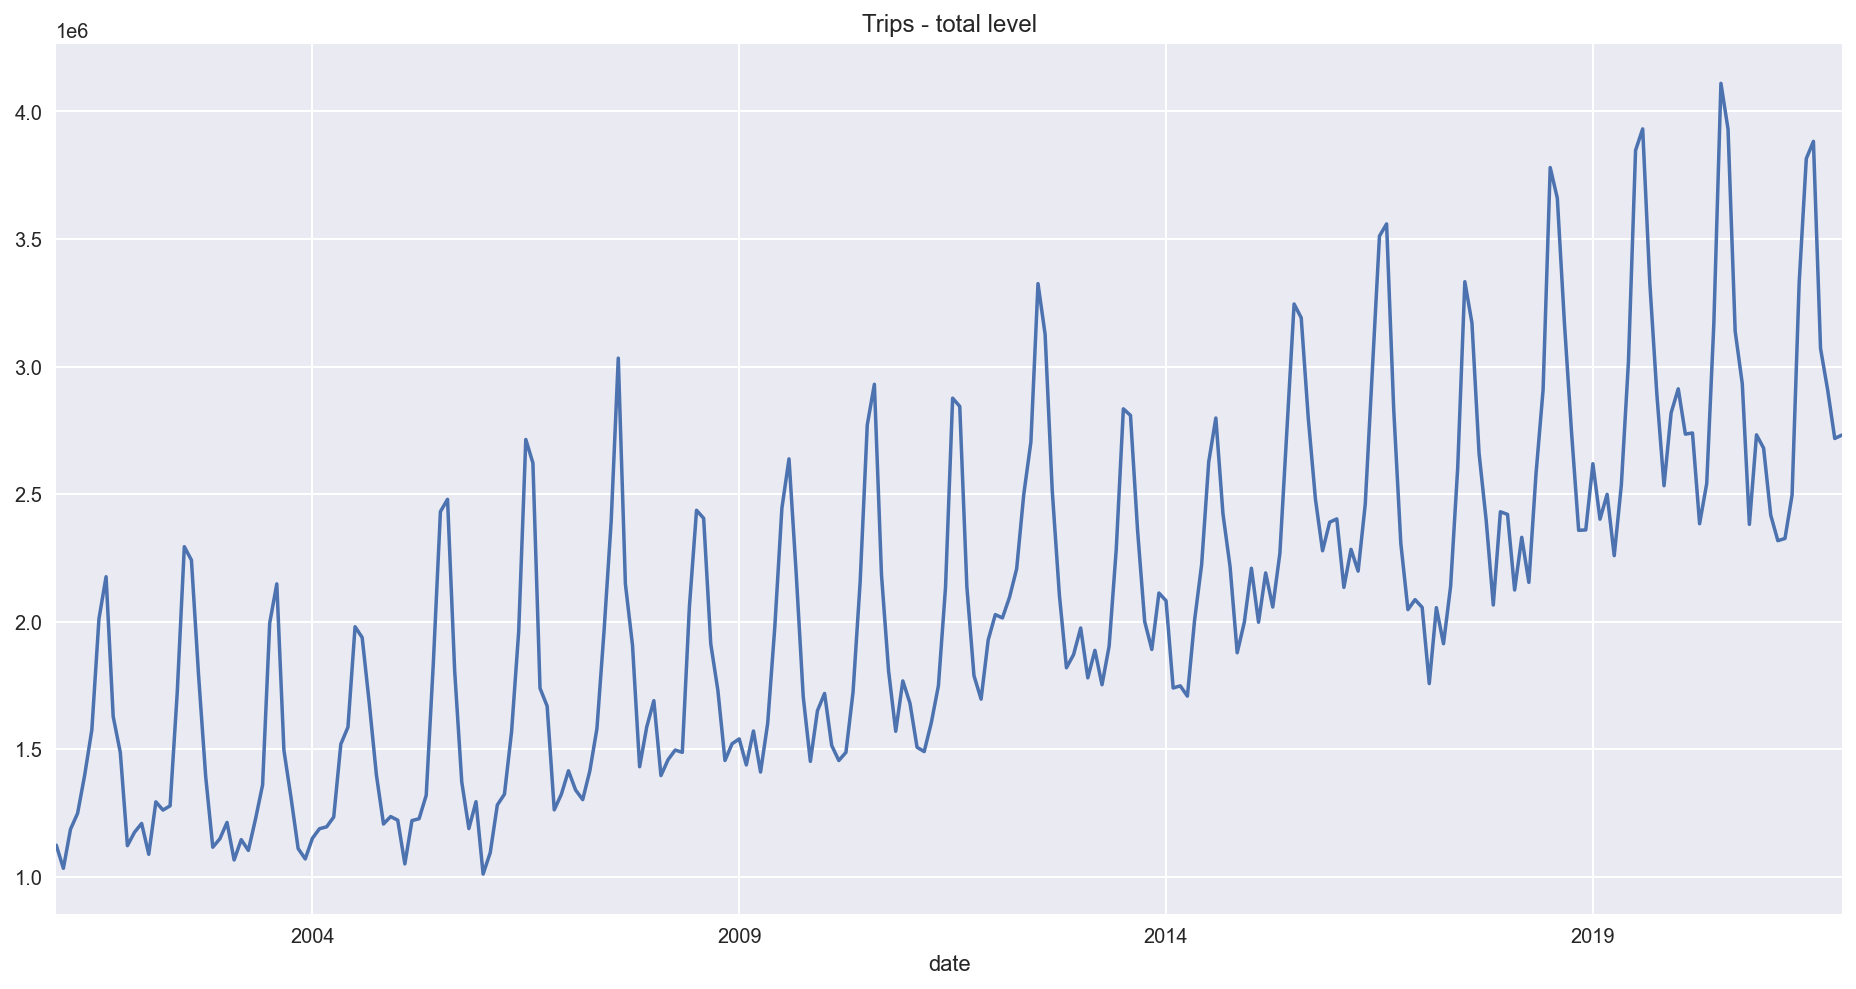

In [10]:
hierarchy_train_df["total"].plot(title="Trips - total level");

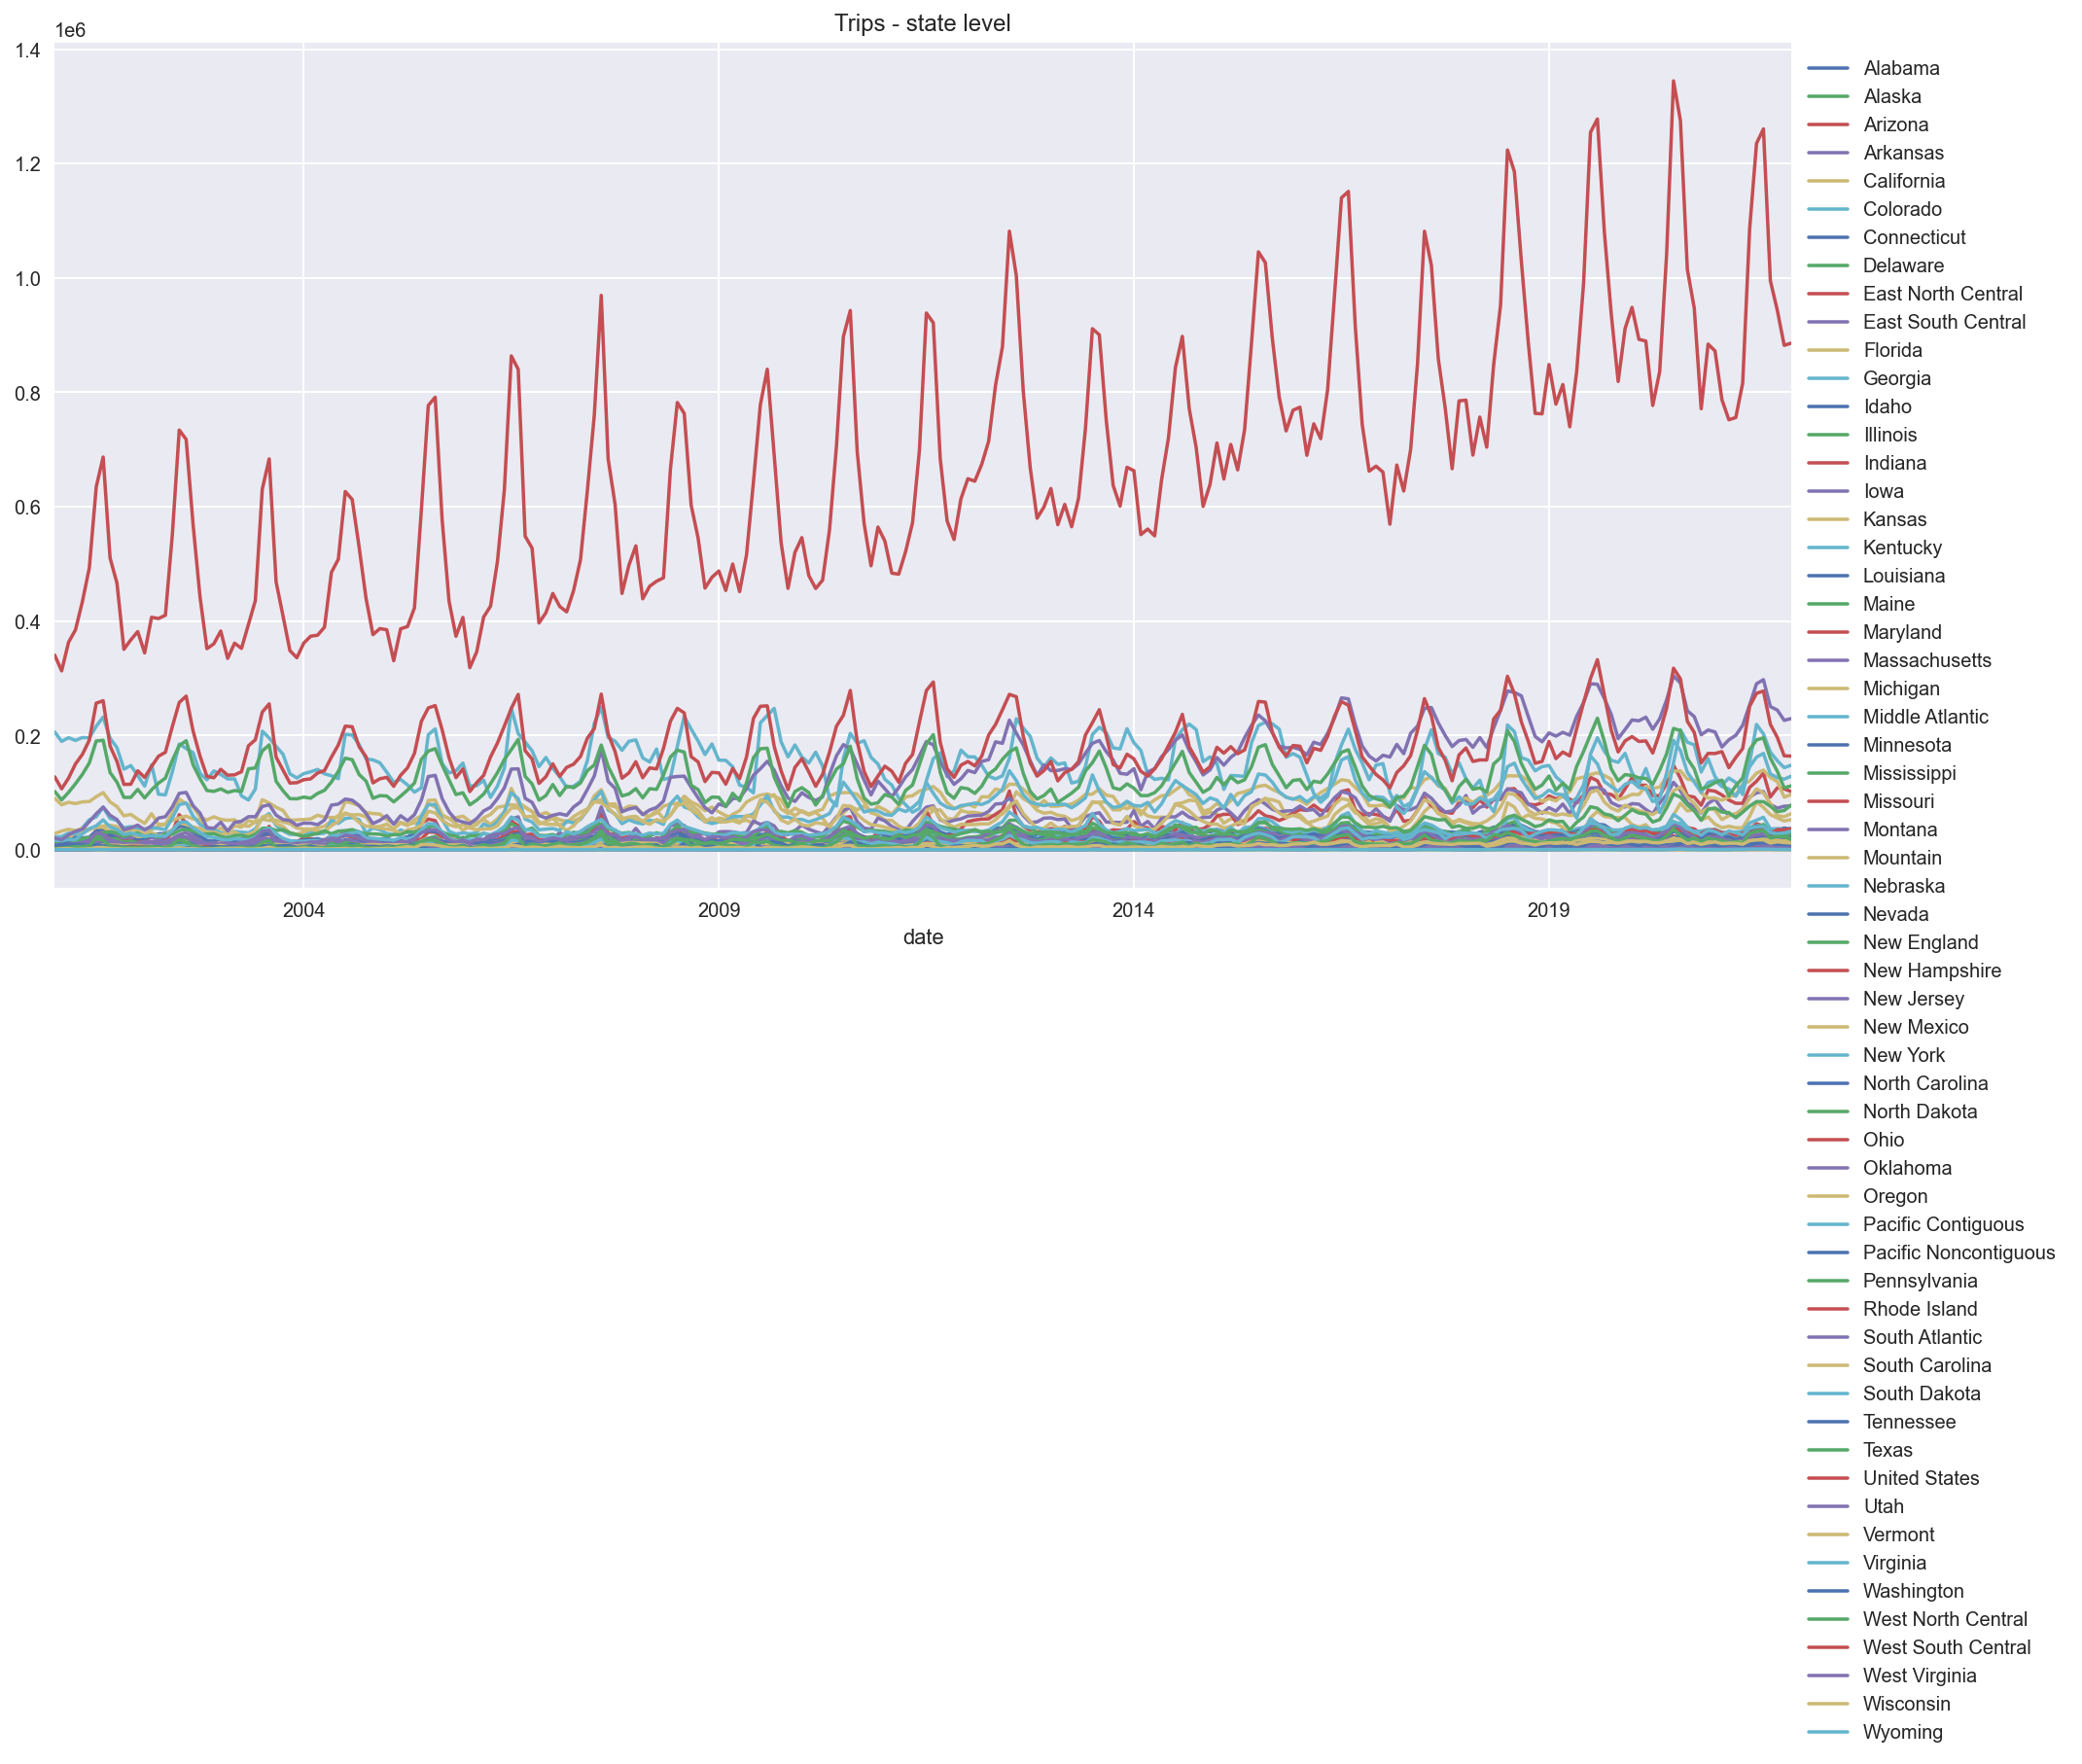

In [11]:
ax = hierarchy_train_df[hierarchy['total']].plot(title="Trips - state level")
ax.legend(bbox_to_anchor=(1.0, 1.0));

In [13]:
def plot_results(pred_df, source_df, cols_to_plot):
    """
    Helper function used for displaying the predictions vs. actuals for the indicated columns
    """
    
    if type(cols_to_plot) == str:
        cols_to_plot = list(cols_to_plot)
        
    for col in cols_to_plot:
        fig, ax = plt.subplots()
        pred_df[col].plot(ax=ax, label="Predicted")
        source_df[col].plot(ax=ax, label="Observed")
        
        ax.legend()
        ax.set_title(col)
        ax.set_xlabel("Date")
        ax.set_ylabel("Trips");

In [44]:
mlflow.set_experiment("Auto-Arima")
experiment = mlflow.get_experiment_by_name("Auto-Arima")
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name = 'OLS'):
    model_td_arima = hts.HTSRegressor(model='auto_arima', revision_method='OLS', n_jobs=0)
    model_td_arima = model_td_arima.fit(hierarchy_train_df, hierarchy)
    pred_td_arima = model_td_arima.predict(steps_ahead=3)
    mape_df = pd.DataFrame(index = ['mape'], columns=['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'East North Central', 'East South Central',
       'Florida', 'Georgia', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Middle Atlantic ', 'Minnesota', 'Mississippi', 'Missouri',
       'Montana', 'Mountain', 'Nebraska', 'Nevada', 'New England ',
       'New Hampshire ', 'New Jersey ', 'New Mexico ', 'New York ',
       'North Carolina ', 'North Dakota ', 'Ohio', 'Oklahoma', 'Oregon',
       'Pacific Contiguous ', 'Pacific Noncontiguous ', 'Pennsylvania',
       'Rhode Island ', 'South Atlantic ', 'South Carolina ', 'South Dakota ',
       'Tennessee', 'Texas', 'United States ', 'Utah', 'Vermont', 'Virginia',
       'Washington', 'West North Central', 'West South Central',
       'West Virginia ', 'Wisconsin', 'Wyoming', 'total'])
    for i in mape_df.columns:
        mape_df.at['mape', i] = mean_absolute_percentage_error(hierarchy_df[i], pred_td_arima[i])
        globals()[i] = mape_df[i][0]
        mlflow.log_metric(i,mape_df[i][0])
    r2=r2_score(hierarchy_df, pred_td_arima)
    mlflow.log_metric("r2", r2)
    
    
    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(model_td_arima, "model", registered_model_name="Auto-Arima")
    else:
        mlflow.sklearn.log_model(model_td_arima, "model")


Fitting models: 100%|██████████| 61/61 [00:00<00:00, 370.67it/s]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x7fd076bc9fd0>


In [45]:
mlflow.set_experiment("Auto-Arima")
experiment = mlflow.get_experiment_by_name("Auto-Arima")
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name = 'BU'):
    model_bu_arima = hts.HTSRegressor(model='auto_arima', revision_method='BU', n_jobs=0)
    model_bu_arima = model_bu_arima.fit(hierarchy_train_df, hierarchy)
    pred_bu_arima = model_bu_arima.predict(steps_ahead=3)
    mape_df = pd.DataFrame(index = ['mape'], columns=['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'East North Central', 'East South Central',
       'Florida', 'Georgia', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Middle Atlantic ', 'Minnesota', 'Mississippi', 'Missouri',
       'Montana', 'Mountain', 'Nebraska', 'Nevada', 'New England ',
       'New Hampshire ', 'New Jersey ', 'New Mexico ', 'New York ',
       'North Carolina ', 'North Dakota ', 'Ohio', 'Oklahoma', 'Oregon',
       'Pacific Contiguous ', 'Pacific Noncontiguous ', 'Pennsylvania',
       'Rhode Island ', 'South Atlantic ', 'South Carolina ', 'South Dakota ',
       'Tennessee', 'Texas', 'United States ', 'Utah', 'Vermont', 'Virginia',
       'Washington', 'West North Central', 'West South Central',
       'West Virginia ', 'Wisconsin', 'Wyoming', 'total'])
    for i in mape_df.columns:
        mape_df.at['mape', i] = mean_absolute_percentage_error(hierarchy_df[i], pred_bu_arima[i])
        globals()[i] = mape_df[i][0]
        mlflow.log_metric(i,mape_df[i][0])
    r2=r2_score(hierarchy_df, pred_bu_arima)
    mlflow.log_metric("r2", r2)
    
    
    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(model_bu_arima, "model", registered_model_name="Auto-Arima_BU")
    else:
        mlflow.sklearn.log_model(model_bu_arima, "model")


Fitting models: 100%|██████████| 61/61 [00:00<00:00, 366.14it/s]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x7fd05b5564c0>


In [46]:
mlflow.set_experiment("Auto-Arima")
experiment = mlflow.get_experiment_by_name("Auto-Arima")
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name = 'AHP'):
    model_ahp_arima = hts.HTSRegressor(model='auto_arima', revision_method='AHP', n_jobs=0)
    model_ahp_arima = model_ahp_arima.fit(hierarchy_train_df, hierarchy)
    pred_ahp_arima = model_ahp_arima.predict(steps_ahead=3)
    mape_df = pd.DataFrame(index = ['mape'], columns=['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'East North Central', 'East South Central',
       'Florida', 'Georgia', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Middle Atlantic ', 'Minnesota', 'Mississippi', 'Missouri',
       'Montana', 'Mountain', 'Nebraska', 'Nevada', 'New England ',
       'New Hampshire ', 'New Jersey ', 'New Mexico ', 'New York ',
       'North Carolina ', 'North Dakota ', 'Ohio', 'Oklahoma', 'Oregon',
       'Pacific Contiguous ', 'Pacific Noncontiguous ', 'Pennsylvania',
       'Rhode Island ', 'South Atlantic ', 'South Carolina ', 'South Dakota ',
       'Tennessee', 'Texas', 'United States ', 'Utah', 'Vermont', 'Virginia',
       'Washington', 'West North Central', 'West South Central',
       'West Virginia ', 'Wisconsin', 'Wyoming', 'total'])
    for i in mape_df.columns:
        mape_df.at['mape', i] = mean_absolute_percentage_error(hierarchy_df[i], pred_ahp_arima[i])
        globals()[i] = mape_df[i][0]
        mlflow.log_metric(i,mape_df[i][0])
    r2=r2_score(hierarchy_df, pred_ahp_arima)
    mlflow.log_metric("r2", r2)
    
    
    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(model_ahp_arima, "model", registered_model_name="Auto-Arima_AHP")
    else:
        mlflow.sklearn.log_model(model_ahp_arima, "model")

Fitting models: 100%|██████████| 61/61 [00:00<00:00, 368.05it/s]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x7fd05b534700>


In [35]:
mlflow.set_experiment("Prophet")
experiment = mlflow.get_experiment_by_name("Prophet")
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name = 'OLS'):
    model_ols_prophet = hts.HTSRegressor(model='prophet', revision_method='OLS', n_jobs=0)
    model_ols_prophet = model_ols_prophet.fit(hierarchy_train_df, hierarchy)
    pred_ols_prophet = model_ols_prophet.predict(steps_ahead=3)
    mape_df = pd.DataFrame(index = ['mape'], columns=['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'East North Central', 'East South Central',
       'Florida', 'Georgia', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Middle Atlantic ', 'Minnesota', 'Mississippi', 'Missouri',
       'Montana', 'Mountain', 'Nebraska', 'Nevada', 'New England ',
       'New Hampshire ', 'New Jersey ', 'New Mexico ', 'New York ',
       'North Carolina ', 'North Dakota ', 'Ohio', 'Oklahoma', 'Oregon',
       'Pacific Contiguous ', 'Pacific Noncontiguous ', 'Pennsylvania',
       'Rhode Island ', 'South Atlantic ', 'South Carolina ', 'South Dakota ',
       'Tennessee', 'Texas', 'United States ', 'Utah', 'Vermont', 'Virginia',
       'Washington', 'West North Central', 'West South Central',
       'West Virginia ', 'Wisconsin', 'Wyoming', 'total'])
    for i in mape_df.columns:
        mape_df.at['mape', i] = mean_absolute_percentage_error(hierarchy_df[i], pred_ols_prophet[i])
        globals()[i] = mape_df[i][0]
        mlflow.log_metric(i,mape_df[i][0])
    r2=r2_score(hierarchy_df, pred_ols_prophet)
    mlflow.log_metric("r2", r2)
    
    
    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(model_ols_prophet, "model", registered_model_name="Prophet")
    else:
        mlflow.sklearn.log_model(model_ols_prophet, "model")



2022/07/13 15:30:15 INFO mlflow.tracking.fluent: Experiment with name 'Prophet' does not exist. Creating a new experiment.
Fitting models:   0%|          | 0/61 [00:00<?, ?it/s]Importing plotly failed. Interactive plots will not work.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:   2%|▏         | 1/61 [00:01<01:28,  1.47s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:   5%|▍         | 3/61 [00:01<00:25,  2.29it/s]INFO:fbprophet:Disablin

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:  57%|█████▋    | 35/61 [00:04<00:02, 11.73it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:  61%|██████    | 37/61 [00:04<00:01, 12.18it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run pr

In [42]:
mlflow.set_experiment("Prophet")
experiment = mlflow.get_experiment_by_name("Prophet")
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name = 'BU'):
    model_bu_prophet = hts.HTSRegressor(model='prophet', revision_method='BU', n_jobs=0)
    model_bu_prophet = model_bu_prophet.fit(hierarchy_train_df, hierarchy)
    pred_bu_prophet = model_bu_prophet.predict(steps_ahead=3)
    mape_df = pd.DataFrame(index = ['mape'], columns=['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'East North Central', 'East South Central',
       'Florida', 'Georgia', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Middle Atlantic ', 'Minnesota', 'Mississippi', 'Missouri',
       'Montana', 'Mountain', 'Nebraska', 'Nevada', 'New England ',
       'New Hampshire ', 'New Jersey ', 'New Mexico ', 'New York ',
       'North Carolina ', 'North Dakota ', 'Ohio', 'Oklahoma', 'Oregon',
       'Pacific Contiguous ', 'Pacific Noncontiguous ', 'Pennsylvania',
       'Rhode Island ', 'South Atlantic ', 'South Carolina ', 'South Dakota ',
       'Tennessee', 'Texas', 'United States ', 'Utah', 'Vermont', 'Virginia',
       'Washington', 'West North Central', 'West South Central',
       'West Virginia ', 'Wisconsin', 'Wyoming', 'total'])
    for i in mape_df.columns:
        mape_df.at['mape', i] = mean_absolute_percentage_error(hierarchy_df[i], pred_bu_prophet[i])
        globals()[i] = mape_df[i][0]
        mlflow.log_metric(i,mape_df[i][0])
    r2=r2_score(hierarchy_df, pred_bu_prophet)
    mlflow.log_metric("r2", r2)
    
    
    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(model_bu_prophet, "model", registered_model_name="Prophet_BU")
    else:
        mlflow.sklearn.log_model(model_bu_prophet, "model")




Fitting models:   0%|          | 0/61 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:   2%|▏         | 1/61 [00:00<00:08,  7.07it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:   5%|▍         | 3/61 [00:00<00:04, 11.74it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:  57%|█████▋    | 35/61 [00:02<00:02, 11.97it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:  61%|██████    | 37/61 [00:03<00:02, 11.65it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run pr

In [43]:
mlflow.set_experiment("Prophet")
experiment = mlflow.get_experiment_by_name("Prophet")
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name = 'AHP'):
    model_ahp_prophet = hts.HTSRegressor(model='prophet', revision_method='AHP', n_jobs=0)
    model_ahp_prophet = model_ahp_prophet.fit(hierarchy_train_df, hierarchy)
    pred_ahp_prophet = model_ahp_prophet.predict(steps_ahead=3)
    mape_df = pd.DataFrame(index = ['mape'], columns=['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'East North Central', 'East South Central',
       'Florida', 'Georgia', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Middle Atlantic ', 'Minnesota', 'Mississippi', 'Missouri',
       'Montana', 'Mountain', 'Nebraska', 'Nevada', 'New England ',
       'New Hampshire ', 'New Jersey ', 'New Mexico ', 'New York ',
       'North Carolina ', 'North Dakota ', 'Ohio', 'Oklahoma', 'Oregon',
       'Pacific Contiguous ', 'Pacific Noncontiguous ', 'Pennsylvania',
       'Rhode Island ', 'South Atlantic ', 'South Carolina ', 'South Dakota ',
       'Tennessee', 'Texas', 'United States ', 'Utah', 'Vermont', 'Virginia',
       'Washington', 'West North Central', 'West South Central',
       'West Virginia ', 'Wisconsin', 'Wyoming', 'total'])
    for i in mape_df.columns:
        mape_df.at['mape', i] = mean_absolute_percentage_error(hierarchy_df[i], pred_ahp_prophet[i])
        globals()[i] = mape_df[i][0]
        mlflow.log_metric(i,mape_df[i][0])
    r2=r2_score(hierarchy_df, pred_ahp_prophet)
    mlflow.log_metric("r2", r2)
    
    
    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(model_ahp_prophet, "model", registered_model_name="Prophet_AHP")
    else:
        mlflow.sklearn.log_model(model_ahp_prophet, "model")

Fitting models:   0%|          | 0/61 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:   2%|▏         | 1/61 [00:00<00:08,  7.15it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:   5%|▍         | 3/61 [00:00<00:05, 11.10it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:  57%|█████▋    | 35/61 [00:02<00:02, 12.15it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:  61%|██████    | 37/61 [00:03<00:01, 12.38it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run pr

In [38]:
mlflow.set_experiment("Sarimax")
experiment = mlflow.get_experiment_by_name("Sarimax")
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name = 'OLS'):
    model_ols_sarimax = hts.HTSRegressor(model='sarimax', revision_method='OLS', n_jobs=0)
    model_ols_sarimax = model_ols_sarimax.fit(hierarchy_train_df, hierarchy)
    pred_ols_sarimax = model_ols_sarimax.predict(steps_ahead=3)
    mape_df = pd.DataFrame(index = ['mape'], columns=['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'East North Central', 'East South Central',
       'Florida', 'Georgia', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Middle Atlantic ', 'Minnesota', 'Mississippi', 'Missouri',
       'Montana', 'Mountain', 'Nebraska', 'Nevada', 'New England ',
       'New Hampshire ', 'New Jersey ', 'New Mexico ', 'New York ',
       'North Carolina ', 'North Dakota ', 'Ohio', 'Oklahoma', 'Oregon',
       'Pacific Contiguous ', 'Pacific Noncontiguous ', 'Pennsylvania',
       'Rhode Island ', 'South Atlantic ', 'South Carolina ', 'South Dakota ',
       'Tennessee', 'Texas', 'United States ', 'Utah', 'Vermont', 'Virginia',
       'Washington', 'West North Central', 'West South Central',
       'West Virginia ', 'Wisconsin', 'Wyoming', 'total'])
    for i in mape_df.columns:
        mape_df.at['mape', i] = mean_absolute_percentage_error(hierarchy_df[i], pred_ols_sarimax[i])
        globals()[i] = mape_df[i][0]
        mlflow.log_metric(i,mape_df[i][0])
    r2=r2_score(hierarchy_df, pred_ols_sarimax)
    mlflow.log_metric("r2", r2)
    
    
    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(model_ols_sarimax, "model", registered_model_name="Sarimax")
    else:
        mlflow.sklearn.log_model(model_ols_sarimax, "model")




2022/07/13 15:41:58 INFO mlflow.tracking.fluent: Experiment with name 'Sarimax' does not exist. Creating a new experiment.
Fitting models: 100%|██████████| 61/61 [00:00<00:00, 429.79it/s]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x7fd05ab37b20>


In [41]:
mlflow.set_experiment("Holt-Winters")
experiment = mlflow.get_experiment_by_name("Holt-Winters")
with mlflow.start_run(experiment_id=experiment.experiment_id, run_name = 'OLS'):
    model_ols_holtw = hts.HTSRegressor(model='holt_winters', revision_method='OLS', n_jobs=0)
    model_ols_holtw = model_ols_holtw.fit(hierarchy_train_df, hierarchy)
    pred_ols_holtw = model_ols_holtw.predict(steps_ahead=3)
    mape_df = pd.DataFrame(index = ['mape'], columns=['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'East North Central', 'East South Central',
       'Florida', 'Georgia', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Middle Atlantic ', 'Minnesota', 'Mississippi', 'Missouri',
       'Montana', 'Mountain', 'Nebraska', 'Nevada', 'New England ',
       'New Hampshire ', 'New Jersey ', 'New Mexico ', 'New York ',
       'North Carolina ', 'North Dakota ', 'Ohio', 'Oklahoma', 'Oregon',
       'Pacific Contiguous ', 'Pacific Noncontiguous ', 'Pennsylvania',
       'Rhode Island ', 'South Atlantic ', 'South Carolina ', 'South Dakota ',
       'Tennessee', 'Texas', 'United States ', 'Utah', 'Vermont', 'Virginia',
       'Washington', 'West North Central', 'West South Central',
       'West Virginia ', 'Wisconsin', 'Wyoming', 'total'])
    for i in mape_df.columns:
        mape_df.at['mape', i] = mean_absolute_percentage_error(hierarchy_df[i], pred_ols_holtw[i])
        globals()[i] = mape_df[i][0]
        mlflow.log_metric(i,mape_df[i][0])
    r2=r2_score(hierarchy_df, pred_ols_holtw)
    mlflow.log_metric("r2", r2)
    
    
    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(model_ols_holtw, "model", registered_model_name="Holt-Winters")
    else:
        mlflow.sklearn.log_model(model_ols_holtw, "model")


2022/07/13 15:44:49 INFO mlflow.tracking.fluent: Experiment with name 'Holt-Winters' does not exist. Creating a new experiment.
Fitting models: 100%|██████████| 61/61 [00:00<00:00, 390.85it/s]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x7fd058c510a0>
